In [6]:
import numpy as np
import matplotlib.pyplot as plt

X=np.loadtxt('sindata.csv',delimiter=',')

在实现算法前，我们先来定义高斯分布密度函数$p(\mathbf{x} \mid \boldsymbol{\mu}, \Sigma)$ 
$$p(\mathbf{x} \mid \boldsymbol{\mu}, \Sigma) = 
\frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} 
\exp\left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^\top \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu}) \right)$$

对数概率密度函数
$$\log p(\mathbf{x} \mid \boldsymbol{\mu}, \Sigma) = 
-\frac{d}{2} \log(2\pi)
- \frac{1}{2} \log |\Sigma|
- \frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^\top \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu})$$

对数似然函数公式
$$\log p(X \mid \theta) = 
\sum_{n=1}^{N} \log \left( \sum_{k=1}^{K} \phi_k \cdot \mathcal{N}(x_n \mid \mu_k, \Sigma_k) \right)$$

采用logsumexp
$$\log p(X \mid \theta) = 
\sum_{n=1}^N \log \left( \sum_{k=1}^K \phi_k \cdot p(x_n \mid \mu_k, \Sigma_k) \right)
= \sum_{n=1}^N \mathrm{logsumexp}_{k=1}^K \left( \log \phi_k + \log p(x_n \mid \mu_k, \Sigma_k) \right)$$

In [3]:
# 计算多元高斯分布的概率密度的对数

#参数
#x :数据点
#mu: 均值向量
#sigma:协方差矩阵
def log_gaussian_prob(x,mu,sigma):
    d=x.shape[-1]
    det=np.linalg.det(sigma)
    diff=x-mu
    #由于x可能包含多个样本  (n_samples, n_features)   sigma (n_features, n_features)
    #x.T @ inv(sigma) @ x 的第二个乘法只需要保留前后样本一致的部分
    #所以第二部分用点乘在求和代替
    log_prob=-d/2*np.log(2*np.pi)-0.5*np.log(det) \
             -0.5*np.sum(diff @ np.linalg.inv(sigma)*diff,axis=-1)
    return log_prob

In [ ]:
from sklearn.cluster import KMeans
from scipy.special import logsumexp

class GMM:

    def __init__(self,n_components=2,eps=1e-4,max_iter=100,init='random'):
        # n_components 高斯分布的数目
        # eps 迭代精度 当对数似然小于eps时迭代终止
        # max_iter 最大迭代次数
        # init 初始方法
        self.k=n_components
        self.eps=eps
        self.max_iter=max_iter
        self.init=init
        self.phi=None  #隐变量的先验分布,即占比
        self.means=None #每个高斯分布的均值
        self.covs=None  #每个高斯分布的协方差
    
    def EM_fit(self,X):

        #初始化参数(先验（占比），means，covs)
        if self.init == 'random' :
            self._random_init_params(X)
        elif self.init == 'kmeans' :
            self._kmeans_init_params(X)
        else :
            raise NotImplementedError
        
        #当前的对数似然的计算
        ll=self._calc_log_likelihood(X) 

        n,d=X.shape

        #开始迭代
        qz = np.zeros((n,self.k)) # z的后验分布

        for t in range(self.max_iter) :
            #E步骤
            for i in range(self.k) :
                # 计算样本属于第i类的概率
                log_prob=log_gaussian_prob(X,self.means[i],self.covs[i])
                qz[:,i]=self.phi[i]*np.exp(log_prob) 
            
            #归一化
            qz=qz/np.sum(qz,axis=1).reshape(-1,1)  #reshape 转换为列向量

            #M步骤
            #将qz的一列全部加起来 得到X属于每一类的概率
            self.phi = np.sum(qz,axis=0) / n #更新隐变量分布

            for i in range(self.k):
                #【解释在下一个代码块】
                # 更新均值
                #qz[:, i, None] None ？ 将 (N,) 变成 (N, 1)，以便与 X 广播相乘 
                self.means[i] = np.sum(qz[:,i,None]*X,axis=0)\
                /n/self.phi[i] 
                # 更新协方差
                diff=X-self.means[i]
                self.covs[i]=(qz[:,i,None]*diff).T @ diff \
                /(n-1)/self.phi[i]
            
            #判断对数似然是否收敛
            new_ll = self._calc_log_likelihood(X)

            if new_ll - ll <= self.eps :
                break
            ll=new_ll

    def _calc_log_likelihood(self, X):
        # 计算当前的对数似然
        ll = 0
        for i in range(self.k):
            log_prob = log_gaussian_prob(X, self.means[i], self.covs[i])
            # 用logsumexp简化计算
            # 该函数底层对对数-求和-指数形式的运算做了优化
            ll += logsumexp(log_prob + np.log(self.phi[i]))
        return ll

    def _random_init_params(self, X):
        self.phi = np.random.uniform(0, 1, self.k) # 随机采样phi
        self.phi /= np.sum(self.phi)
        self.means = np.random.uniform(np.min(X), np.max(X), 
            (self.k, X.shape[1])) # 随机采样均值
        self.covs = np.random.uniform(-1, 1, 
            (self.k, X.shape[1], X.shape[1])) # 随机采样协方差
        self.covs += np.eye(X.shape[1]) * X.shape[1] # 加上维度倍的单位矩阵

    def _kmeans_init_params(self, X):
        # 用Kmeans算法初始化参数
        # 简单起见，我们直接调用sklearn库中的Kmeans方法
        kmeans = KMeans(n_clusters=self.k, init='random', 
            n_init='auto', random_state=0).fit(X)
        # 计算高斯分布占比
        data_in_cls = np.bincount(kmeans.labels_, minlength=self.k)
        self.phi = data_in_cls / len(X)
        # 计算均值和协方差
        self.means = np.zeros((self.k, X.shape[1]))
        self.covs = np.zeros((self.k, X.shape[1], X.shape[1]))
        for i in range(self.k):
            # 取出属于第i类的样本
            X_i = X[kmeans.labels_ == i]
            self.means[i] = np.mean(X_i, axis=0)
            diff = X_i - self.means[i]
            self.covs[i] = diff.T @ diff / (len(X_i) - 1)        

M-step：更新均值（Mean）

$$\boldsymbol{\mu}_k 
= \frac{\sum_{i=1}^n q(z_{ik}) \cdot \mathbf{x}_i}{\sum_{i=1}^n q(z_{ik})}
= \frac{\sum_{i=1}^n q(z_{ik}) \cdot \mathbf{x}_i}{n \cdot \phi_k}$$

M-step：更新协方差

$$\boldsymbol{\Sigma}_k 
= \frac{1}{\sum_{i=1}^n q(z_{ik})}
\sum_{i=1}^n q(z_{ik}) \cdot (\mathbf{x}_i - \boldsymbol{\mu}_k)(\mathbf{x}_i - \boldsymbol{\mu}_k)^\top
= \frac{1}{n \cdot \phi_k}
\sum_{i=1}^n q(z_{ik}) \cdot (\mathbf{x}_i - \boldsymbol{\mu}_k)(\mathbf{x}_i - \boldsymbol{\mu}_k)^\top$$


In [11]:
import matplotlib as mpl

def plot_elipses(gmm, ax):
    # 绘制椭圆
    # gmm：GMM模型
    # ax：matplotlib的画布
    covs = gmm.covs
    for i in range(len(covs)):
        # 计算椭圆参数
        cov = covs[i][:2, :2]
        v, w = np.linalg.eigh(cov)
        u = w[0] / np.linalg.norm(w[0])
        ang = np.arctan2(u[1], u[0])
        ang = ang * 180 / np.pi
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        # 设置椭圆的绘制参数
        # facecolor和edgecolor分别是填充颜色和边缘颜色
        # 可以自由调整
        elp = mpl.patches.Ellipse(gmm.means[i, :2], v[0], v[1], 
            angle=180 + ang, facecolor='orange', edgecolor='none')
        elp.set_clip_box(ax.bbox)
        # 设置透明度
        elp.set_alpha(0.5)
        ax.add_artist(elp)

以下是 GMM 模型训练与可视化的完整流程图：

``` python
开始
│
├── 准备数据 X（二维）
│
├── 设置 GMM 超参数：
│    ├─ n_components: [2, 3, 5, 10]
│    ├─ init: ['random', 'kmeans']
│    ├─ max_iter = 100
│    └─ eps = 1e-4
│
├── 创建绘图画布（fig, axes）
│
├── 循环每种配置（共8种组合）：
│    │
│    ├── 初始化 GMM 模型
│    │
│    ├── 根据 init 参数选择初始化方法：
│    │    ├─ 'random' → 随机初始化均值、协方差、先验
│    │    └─ 'kmeans' → 使用 KMeans 结果初始化
│    │
│    ├── 执行 EM_fit(X) 训练模型：
│    │    │
│    │    ├── 初始化 phi, means, covs
│    │    │
│    │    ├── 计算初始对数似然 ll
│    │    │
│    │    ├── 进入迭代循环（最多 max_iter 次）：
│    │    │    │
│    │    │    ├── E-step：
│    │    │    │   对每个高斯成分 i：
│    │    │    │      - 计算 log_prob = log(N(x | μ_i, Σ_i))
│    │    │    │      - qz[:,i] = phi[i] * exp(log_prob)
│    │    │    │   归一化 qz（按行求和）
│    │    │    │
│    │    │    ├── M-step：
│    │    │    │   更新 phi[i] = mean(qz[:,i])
│    │    │    │   更新 means[i] = 加权平均
│    │    │    │   更新 covs[i] = 加权协方差矩阵
│    │    │    │
│    │    │    ├── 计算新对数似然 new_ll
│    │    │    │
│    │    │    ├── 判断是否收敛：new_ll - ll < eps？
│    │    │         是 → 停止迭代
│    │    │         否 → 继续迭代
│    │    │
│    │    └── 完成训练后返回更新后的模型参数
│    │
│    ├── 调用 plot_elipses(gmm, ax)：
│    │    对每个高斯成分 i：
│    │       - 取出 means[i], covs[i]
│    │       - 特征分解协方差矩阵得到主轴方向和长度
│    │       - 在当前子图上绘制椭圆表示该高斯分布
│    │
│    ├── 绘制原始数据点 scatter(X[:, 0], X[:, 1])
│    │
│    └── 设置标题并保存图像
│
└── 所有配置完成 → 显示图像 plt.show()
```

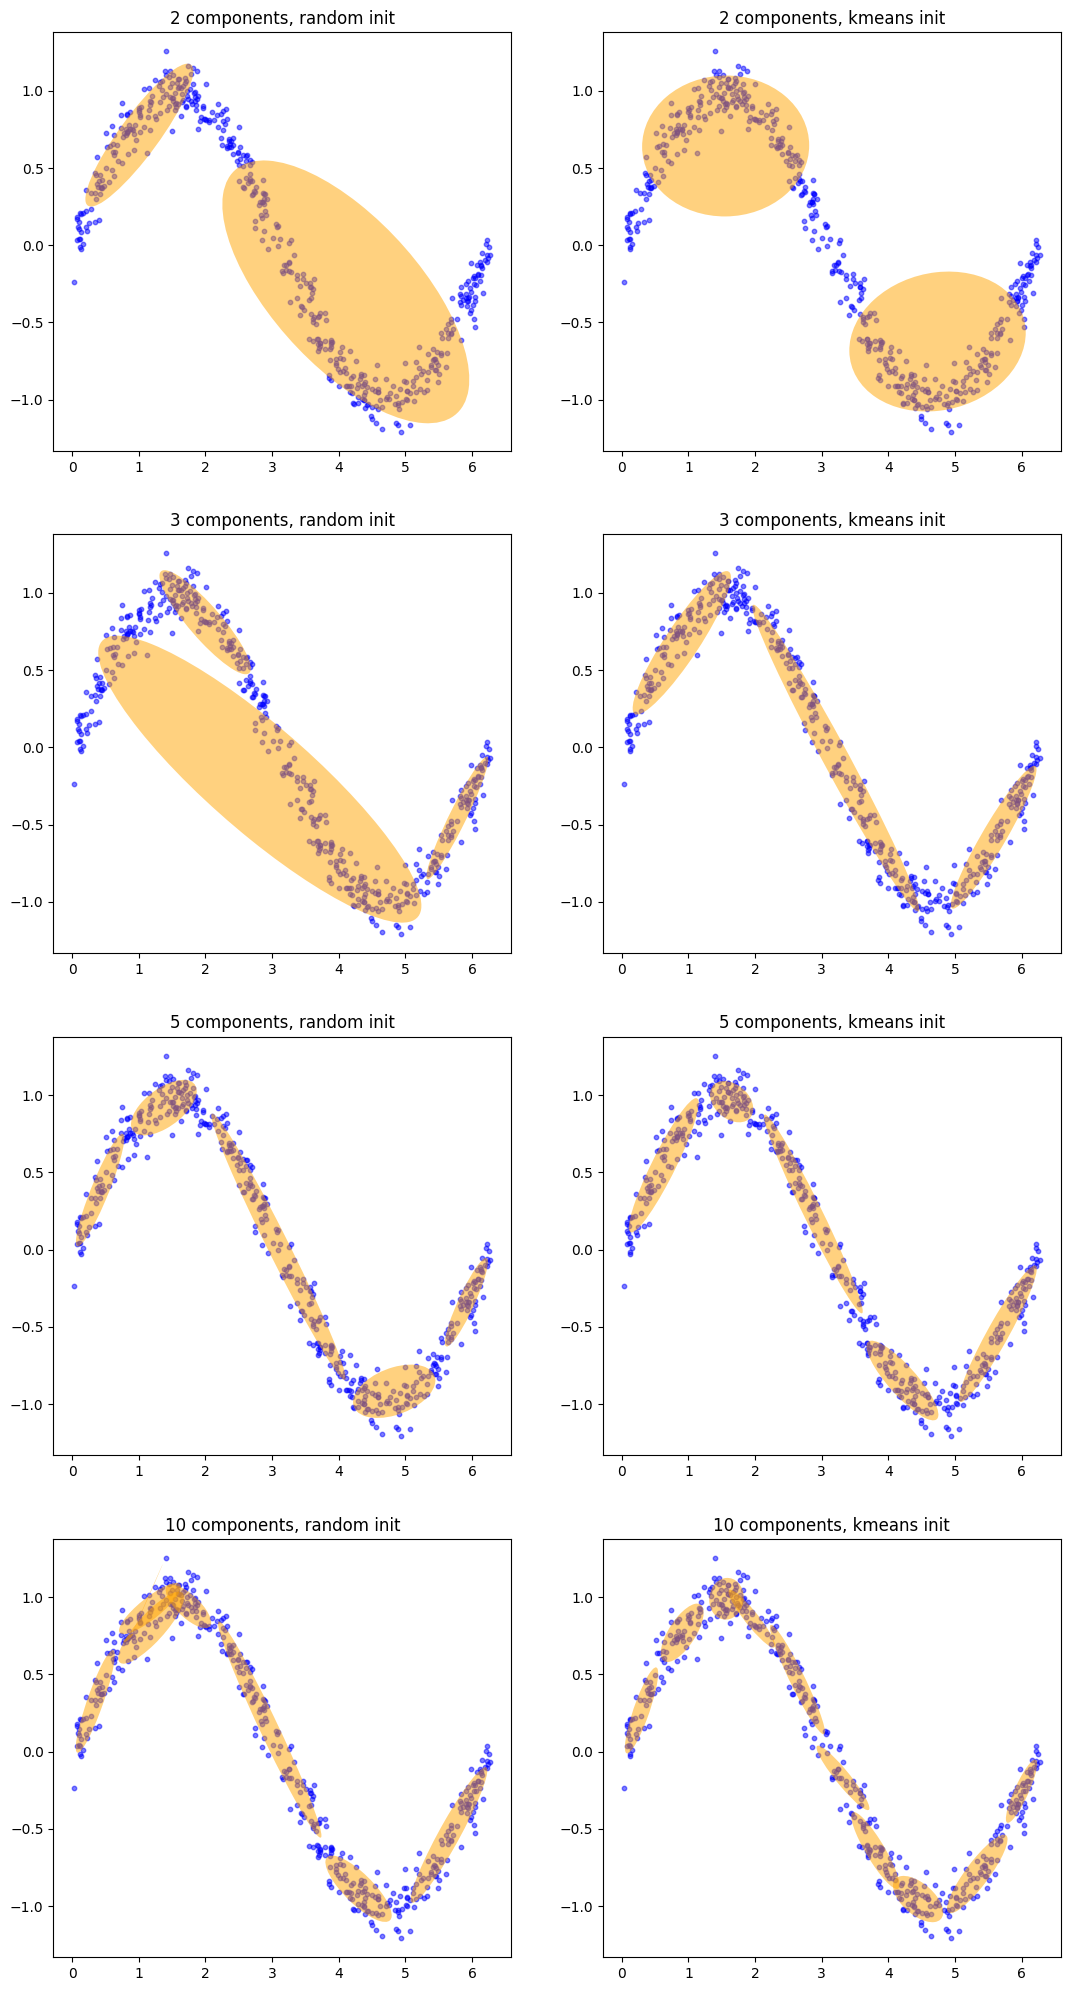

In [21]:
# 超参数
max_iter = 100
eps = 1e-4
np.random.seed(0)

n_components = [2, 3, 5, 10]
inits = ['random', 'kmeans']
fig = plt.figure(figsize=(13, 25))
for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    # 绘制原本的数据点
    ax.scatter(X[:, 0], X[:, 1], color='blue', s=10, alpha=0.5)
    # 初始化并拟合GMM
    k = n_components[i // 2]
    init = inits[i % 2]
    gmm = GMM(k, eps, max_iter, init)
    gmm.EM_fit(X)
    # 绘制椭圆
    plot_elipses(gmm, ax)
    ax.set_title(f'{k} components, {init} init')
plt.show()